# Modeling

In [25]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import product
from collections import defaultdict
from sqlalchemy import create_engine
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import sys
sys.path.append("../model")
from build_model import get_data
from pipeline import Pipeline
import constants as C

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions.float_format = '{:.2f}'.format

In [7]:
# taken from churn case study solution
def plot_feature_importances(df, feature_importances):
    feat_scores = pd.DataFrame({'Mean Decrease Impurity' : feature_importances},
                           index=KEEP)
    feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
    feat_scores.plot(kind='barh', figsize=(8,8))

In [8]:
# stolen from sklearn's example
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ["Finished", "Cancelled"], rotation=45)
    plt.yticks(np.arange(2), ["Finished", "Cancelled"])
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
# ripped from sklearn as well
def plot_roc_curve(fpr, tpr, thresholds, auc):
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
def get_past_ride_cnt(df, y):
    d = defaultdict(list)
    ride_history = []
    for i, user_id in enumerate(df["user_id"]):
        ride_history.append(d[user_id].copy())
        if y is not None:
            d[user_id].append(y[i])
    return ride_history

def change_datetimes(df, *args):
    for col_name in args:
        df[col_name] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df[col_name], 'D')
    return df

def calculate_time_between(df, **kwargs):
    for k, (v1, v2) in kwargs.items():
        df[k] = (df[v1] - df[v2]).dt.total_seconds() / 86400
    return df

### Read data

In [2]:
engine = create_engine(C.ENGINE)
df = get_data(engine)
df["current_state"] = ((df["current_state"] != "finished") & (df["current_state"] != "started")).astype(int)
y = df.pop("current_state").values
y_mean = y.mean()

In [91]:
df.shape

(456387, 19)

In [14]:
df_temp = df.copy()
df_temp["rides"] = get_past_ride_cnt(df_temp, y)
df_temp["past_rides"] = df_temp["rides"].apply(lambda lst: len(lst))
df_temp["past_cancellations"] = df_temp["rides"].apply(lambda lst: sum(lst))
df_temp["past_percent_cancelled"] = df_temp["past_cancellations"] / df_temp["past_rides"]
df_temp["past_percent_cancelled"] = df_temp["past_percent_cancelled"].fillna(y_mean)

df_temp = change_datetimes(df_temp, "pickup", "dropoff", "created_at", "updated_at", "created_at_user")
df_temp = calculate_time_between(df_temp, days_to_pickup=("pickup", "created_at"), trip_duration=("dropoff", "pickup"))
df_temp["pickup_dow"] = df_temp["pickup"].dt.dayofweek
df_temp["weekend_pickup"] = df_temp["pickup_dow"].isin([4, 5, 6]).astype(int)
df_temp["winter_pickup"] = df_temp["pickup"].dt.month.isin([1, 12]).astype(int)
df_temp["western_pickup"] = ((df_temp["time_zone"] == "pst") | (df_temp["time_zone"] == "mst")).astype(int)

df_temp["used_promo"] = df_temp["promo_code_id"].notnull().astype(int)
df_temp["used_referral"] = df_temp["referral_code"].notnull().astype(int)
df_temp["credit_card"] = df_temp["postal_code"].notnull().astype(int)
df_temp["web_booking"] = (df_temp["booking_application"] == "web").astype(int)
df_temp["new_customer"] = (df_temp["reservation_frequency"] == "new_customer").astype(int)
df_temp["modified_profile"] = (df_temp["updated_at"] > df_temp["created_at_user"])
df_temp["modified_profile_after_day1"] = (df_temp["updated_at"].dt.date > df_temp["created_at_user"].dt.date)

In [15]:
KEEP = ["created_as_guest", "local_rental", "awards_referral_bonus", "is_gds_user",
        "insurance_corporate", "insurance_personal", "insurance_silvercar", "days_to_pickup",
        "trip_duration", "weekend_pickup", "winter_pickup", "used_promo", "used_referral",
        "credit_card", "web_booking", "new_customer", "past_rides", "past_cancellations",
        "past_percent_cancelled", "pickup_dow", "modified_profile", "modified_profile_after_day1", "western_pickup"]
df_temp = df_temp[KEEP].fillna(0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_temp, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
probabilities = clf.predict_proba(X_test)[:, 1]
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7833247149355373
Precision: 0.8418887387940562
Recall: 0.5835213005915649


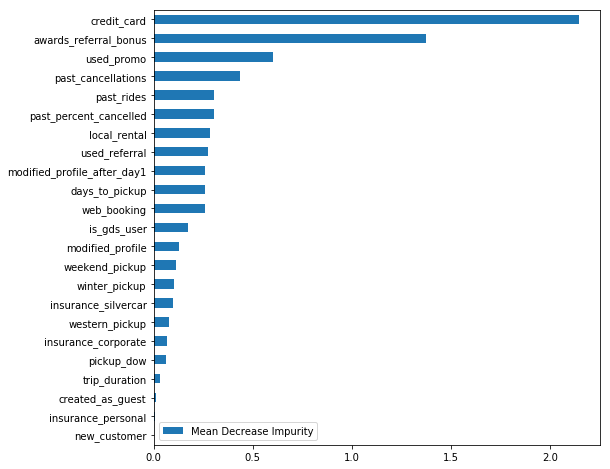

In [18]:
plot_feature_importances(X_train, np.abs(clf.coef_[0]))

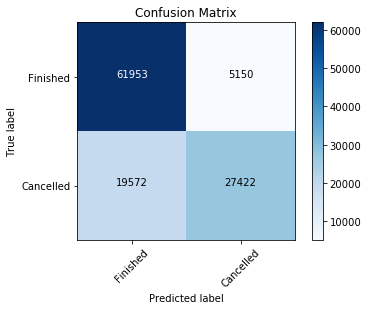

In [19]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

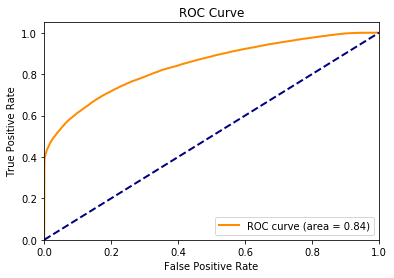

In [20]:
fpr, tpr, thresholds =  roc_curve(y_test, probabilities)
auc = roc_auc_score(y_test, probabilities)
plot_roc_curve(fpr, tpr, thresholds, auc)

### Test different models

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_temp, y, test_size=0.2)

In [22]:
parameters = {"C": np.logspace(-2, 2, 10)}
clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
predictions = clf.predict(X_test)
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7823243278774732
Precision: 0.8363286511448913
Recall: 0.5818785477133983


In [26]:
clf = SGDClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7545191612436731
Precision: 0.6950165766047981
Recall: 0.7128628038984685


In [27]:
parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10]}
clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.7935318477617826
Precision: 0.8386163982430453
Recall: 0.613446503159473


In [ ]:
clf = GradientBoostingClassifier(n_estimators=20, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
clf.fit(X_train, y_train)
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

### Feature Selection